# Final Initial Data Analysis and Preprocessing

This Pipeline is performing data preprocessing pipeline required to run the end-to-end pipeline for the project.

The steps involved in preprocessing involves:
- Setup Data Loading and Writing form Google Drive
- Process the slides at different zoom levels: 4, 5, 7

# Starter code

In [0]:
local = False

In [2]:
# Install the OpenSlide C library and Python bindings
if not local:
    !apt-get install openslide-tools
    !pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 2s (58.4 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [3]:
if not local:
    %tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import random
import time
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

import matplotlib.gridspec as gridspec
import matplotlib.patches as mp_patches

from openslide import open_slide, __library_version__ as openslide_version
from PIL import Image
from skimage.color import rgb2gray
from matplotlib import gridspec
from tensorflow.keras import layers

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Project Setup and Definitions

- [x] Setup Google Drive connection
- [x] Set slides_folder where we store slides



In [0]:
LEVEL_DIR = "/content/drive/My Drive/level_4"
SLIDE_DIR = "/content/drive/My Drive/slides_copy"
SLIDE_FILE = "Copy of tumor_{id}.tif"
TUMOR_FILE = "Copy of tumor_{id}_mask.tif"
MODEL_TAG = "lvl4"
LEVEL = 4

In [0]:
if not local:
    folder_root = "/content/drive/My Drive/4995-final"
    slides_folder = os.path.join(folder_root, 'slides')
else:
    folder_root = '.'
    slides_folder = '.'

In [0]:
if not os.path.exists(folder_root):
  os.mkdir(folder_root)

if not os.path.exists(slides_folder):
  os.mkdir(slides_folder)

In [0]:
# Download an example slide and tumor mask

# Note: the remainder of the training data are in the Google Drive folder linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

if not os.path.exists(os.path.join(slides_folder, slide_path)):
    slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
    mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

    # Download the whole slide image
    if not os.path.exists(slide_path):
      !curl -O $slide_url

    # Download the tumor mask
    if not os.path.exists(tumor_mask_path):
      !curl -O $mask_url

In [0]:
if "content" not in slide_path and os.path.exists(slide_path):
  !mv /content/$slide_path "$slides_folder"/$slide_path

if "content" not in slide_path:
  slide_path = os.path.join(slides_folder, slide_path)

slide_path

'/content/drive/My Drive/4995-final/slides/tumor_091.tif'

In [0]:
if "content" not in tumor_mask_path and os.path.exists(tumor_mask_path):
  !mv /content/$tumor_mask_path "$slides_folder"/$tumor_mask_path

if "content" not in tumor_mask_path:
  tumor_mask_path = os.path.join(slides_folder, tumor_mask_path)

tumor_mask_path

'/content/drive/My Drive/4995-final/slides/tumor_091_mask.tif'

In [0]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from /content/drive/My Drive/4995-final/slides/tumor_091.tif with width: 61440, height: 53760
Read tumor mask from /content/drive/My Drive/4995-final/slides/tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


# Slide-related functions

- [x] Reading the Slides
- [x] Finding tissue pixels in a patch: used to ignore non tissue areas during patch extraction
- [x] Create a tissue mask out of a slide image

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

def create_tissue_mask(im, mask, color=(1,1,1)):
    masked = np.zeros(im.shape)
    for x,y in mask: masked[x][y] = color
    return masked

def get_downsample_ratio(level):
  return 2**level

In [0]:
def get_downsampled_pos(x0, y0, lvl):
    x = int(round(x0 / get_downsample_ratio(lvl)))
    y = int(round(y0 / get_downsample_ratio(lvl)))
    
    return x, y

def get_relative_pos(x1, y1, lvl1, lvl2):
    x0 = x1 * get_downsample_ratio(lvl1)
    y0 = y1 * get_downsample_ratio(lvl1)
    
    return get_downsampled_pos(x0, y0, lvl2)

### Locate the patch center for different zoom levels

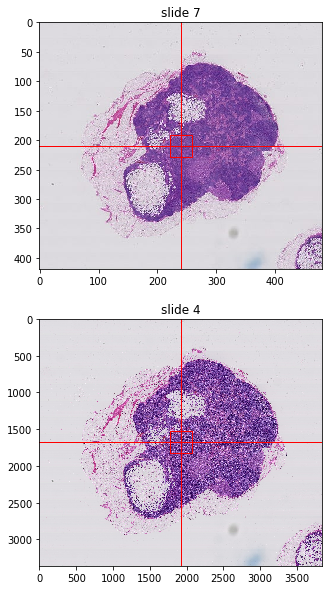

In [0]:
# Using actual patch (299 x 299) with 128 center
num = 2
fig, axes = plt.subplots(num, 1, figsize=(10 * num, 10))
i = 0

# center of image
base_lvl = 4
patch_size = (299, 299)
coord_lvl = (int((slide.level_dimensions[base_lvl][0] - patch_size[0]) / 2), 
             int((slide.level_dimensions[base_lvl][1] - patch_size[1]) / 2))

# Level 7
lvl = 7
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=lvl, 
                         width=slide.level_dimensions[lvl][0], 
                         height=slide.level_dimensions[lvl][1])

patch_scaled = get_relative_pos(patch_size[0], patch_size[1], base_lvl, lvl)
rect = mp_patches.Rectangle(get_relative_pos(coord_lvl[0], coord_lvl[1], base_lvl, lvl),
                         patch_scaled[0], patch_scaled[1], linewidth=1, edgecolor='r', facecolor='none')
axes[i].axhline(y=int(slide.level_dimensions[lvl][1]/2), color='r', linestyle='-', linewidth=1)
axes[i].axvline(x=int(slide.level_dimensions[lvl][0]/2), color='r', linestyle='-', linewidth=1)
axes[i].set_title("slide {}".format(lvl))
axes[i].imshow(slide_image)
axes[i].add_patch(rect)
i += 1

# Level 4
lvl = 4
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=lvl, 
                         width=slide.level_dimensions[lvl][0], 
                         height=slide.level_dimensions[lvl][1])

rect = mp_patches.Rectangle(get_relative_pos(coord_lvl[0], coord_lvl[1], base_lvl, lvl),
                         299, 299, linewidth=1, edgecolor='r', facecolor='none')
axes[i].axhline(y=int(slide.level_dimensions[lvl][1]/2), color='r', linestyle='-', linewidth=1)
axes[i].axvline(x=int(slide.level_dimensions[lvl][0]/2), color='r', linestyle='-', linewidth=1)
axes[i].set_title("slide {}".format(lvl))
axes[i].imshow(slide_image)
axes[i].add_patch(rect)
i += 1

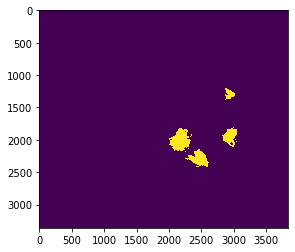

In [0]:
# See tumor Slides
lvl = 4
slide_tumor = read_slide(tumor_mask, 
                         x=0, 
                         y=0, 
                         level=lvl, 
                         width=slide.level_dimensions[lvl][0], 
                         height=slide.level_dimensions[lvl][1])
slide_tumor = slide_tumor[:,:,0]
plt.imshow(slide_tumor)

Text(0.5, 1.0, 'Tissue mask')

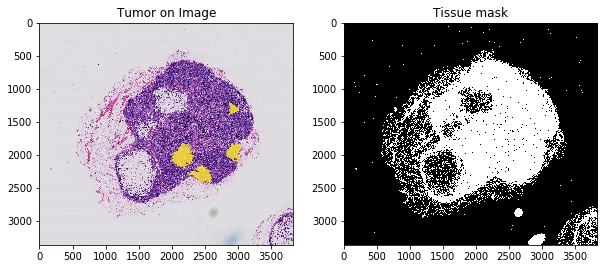

In [0]:
# See tissue pixels
lvl = 4

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
tissue_pixels = find_tissue_pixels(slide_image)
tissue_mask = create_tissue_mask(slide_image, tissue_pixels)

axes[0].imshow(slide_image)
axes[0].imshow(np.ma.masked_values(slide_tumor, 0), 
               cmap='viridis', vmin=0, vmax=1, alpha=0.8)
axes[0].set_title("Tumor on Image")

axes[1].imshow(tissue_mask, cmap='viridis', vmin=0, vmax=1)
axes[1].set_title("Tissue mask")

# Data Loading, Patch and Label Extraction

- [x] Loading Slides
- [x] Extract random patches, tumor masks, labels and tissues from a slide
  - [x] Recognize healthy and tumorous tissues
  - [x] Label: Check if a mask patch contains a tumor at the center
- [x] Handle data imbalance by setting an almost equal prob between healthy and tumor, randomly sample from this probability
- [x] Save precomputed patch, mask, and label for further use in modelling and evaluation

In [0]:
def is_patch_tumor(mask, patch_center):
  """Check if the patch within patch_center x patch_center contains tumor
  
  mask: the tumor mask
  patch_center: the patch centroid and size
  """
  y = int(round(mask.shape[0]/2)) - int(round(patch_center/2))
  x = int(round(mask.shape[1]/2)) - int(round(patch_center/2))
  center_region = mask[y:y+patch_center, x:x+patch_center]

  return np.sum(center_region) > 0

def get_dim_from_slide(slide, lvl):
  """Get the dimension of a level

  slide: a slide image
  lvl: a level
  """
  return int(slide.level_downsamples[lvl])

def extract_patches_only_from_center(x, y, slide, tumor_mask, lvl, patch_size):
  """Extract slide and tumor patches.

  x: x-axis center
  y: y-axis center
  slide: the full image slide
  tumor_mask: the full tumor mask slide
  lvl: zoom level
  patch_size: the size of the patch
  """
  dim = get_dim_from_slide(slide, lvl)
    
  # extract slide image by patch_size x patch_size centered at patch_center x patch_center size
  slide_patch = read_slide(
    slide, 
    x=(x - patch_size//2)*dim, 
    y=(y - patch_size//2)*dim,
    level=lvl, 
    width=patch_size, 
    height=patch_size
  )

  # extract tumor by patch_size x patch_size centered at patch_center x patch_center size
  tumor_patch = read_slide(
      tumor_mask, 
      x=(x - patch_size//2)*dim, 
      y=(y - patch_size//2)*dim,
      level=lvl, 
      width=patch_size, 
      height=patch_size
  )

  # tumor patch just use one channel
  tumor_patch = tumor_patch[:, :, 0]

  return slide_patch, tumor_patch

def extract_patches_from_center(x, y, slide, tumor_mask, lvl, patch_size):
  """Extract slide, tumor and tissue regions

  x: x-axis center
  y: y-axis center
  slide: the full image slide
  tumor_mask: the full tumor mask slide
  lvl: zoom level
  patch_size: the size of the patch
  """
  slide_patch, tumor_patch = extract_patches_only_from_center(x, y, slide, 
                                                              tumor_mask, lvl, patch_size)
  
  # extract tissue pixels
  tissue_pixels = find_tissue_pixels(slide_patch)
  percent_tissue = len(tissue_pixels) / float(slide_patch.shape[0] * slide_patch.shape[0]) * 100
  
  return slide_patch, tumor_patch, tissue_pixels, percent_tissue

def extract_patches(slide, tumor_mask, lvl, patch_center=128, patch_size=299, 
                    max_patches=100, plot_patch=False, healthy_ratio=0.6):
  """Extract slide and tumor patches and labels to build the training data for a slide

  slide: slide for the image
  tumor mask: slide for the mask
  lvl: zoom level
  max_patches: how many patches to extract
  plot_patch: boolean to indicate plotting the image
  healthy_ratio: the ratio between healthy and tumor patches
  """
  print("===Start Extracting patches..===")
  start_time = time.time() / 60
  data_patches, data_masks, data_labels, data_tissues = [], [], [], []
  
  # number of possible patches
  dim = int(tumor_mask.level_downsamples[lvl])
  
  # extract full patch
  slide_image = read_slide(
    slide, 
    x=0, 
    y=0,
    level=lvl, 
    width=slide.level_dimensions[lvl][0], 
    height=slide.level_dimensions[lvl][1]
  )
  
  # extract tumor patches
  tumor_image = read_slide(
    tumor_mask, 
    x=0, 
    y=0,
    level=lvl, 
    width=tumor_mask.level_dimensions[lvl][0], 
    height=tumor_mask.level_dimensions[lvl][1]
  )
  # tumor patch just use one channel
  tumor_image = tumor_image[:,:,0]
  
  # check if it's a tissue pixels
  tissue_pixels = find_tissue_pixels(slide_image)
  tissue_masked = create_tissue_mask(slide_image, tissue_pixels)

  tissue_healthy = tissue_masked[:,:,0] - tumor_image
  tissue_healthy[tissue_healthy < 0] = 0
  
  # extract tumorous patches, returns indexes (arr[y], arr[x])
  tissue_tumor_idx = np.where(tumor_image > 0)
  
  # extract healthy patches, returns indexes (arr[y], arr[x])
  tissue_healthy_idx = np.where(tissue_healthy > 0)
  
  print("#tumorous tissue pixels: {}, #healthy tissue pixels: {}".format(
    len(tissue_tumor_idx[0]),
    len(tissue_healthy_idx[0]),
  ))
  
  # sample from tumor pixels (x, y)
  max_tumor = int(max_patches * (1 - healthy_ratio))
  tumor_pixels = random.sample(list(zip(tissue_tumor_idx[1], tissue_tumor_idx[0])), 
                                min(1000, len(tissue_tumor_idx[0]) // 2))
  
  # sample from healthy pixels (x, y)
  max_healthy = int(max_patches * healthy_ratio)
  healthy_pixels = random.sample(list(zip(tissue_healthy_idx[1], tissue_healthy_idx[0])), 
                                  min(5000, len(tissue_healthy_idx[0]) // 2))
  
  # extract tumor patches
  count_tumor = 0
  while len(tumor_pixels) != 0 and count_tumor < max_tumor:
    (x, y) = tumor_pixels.pop()
      
    # extract center patches
    slide_patch, tumor_patch, tissue_patch, percent_tissue = \
      extract_patches_from_center(x, y, slide, tumor_mask, lvl, patch_size)
      
    # add to healthy if it's not a tumor
    if percent_tissue > 50 and is_patch_tumor(tumor_patch, patch_center):
      data_patches.append(slide_patch)
      data_masks.append(tumor_patch)
      data_labels.append(1)
      
      count_tumor += 1
  
  # extract healthy patches
  count_healthy = 0
  while len(healthy_pixels) != 0 and count_healthy < max_healthy:
    (x, y) = healthy_pixels.pop()
    
    # extract center patches
    slide_patch, tumor_patch, tissue_patch, percent_tissue = \
        extract_patches_from_center(x, y, slide, tumor_mask, lvl, patch_size)

    # check if it's a tissue pixels
    tissue_pixels = find_tissue_pixels(slide_patch)
    percent_tissue = len(tissue_pixels) / float(slide_patch.shape[0] * slide_patch.shape[0]) * 100
    
    # add to healthy if it's not a tumor
    if percent_tissue > 50 and not is_patch_tumor(tumor_patch, patch_center):
      data_patches.append(slide_patch)
      data_masks.append(tumor_patch)
      data_labels.append(0)
      
      count_healthy += 1
  
  print("Tumor Patches: {}, Healthy Patches: {}".format(count_tumor, count_healthy))
  data_patches, data_masks, data_labels = (
    np.array(data_patches), 
    np.array(data_masks), 
    np.array(data_labels)
  )
  extraction_time = time.time()/60 - start_time
  
  if plot_patch:
    # plot images
    fig, axes = plt.subplots(1, 4, figsize=(15, 15))
    axes[0].imshow(slide_image)
    axes[0].set_title("full slide")

    axes[1].imshow(tumor_image)
    axes[1].set_title("full tumor mask")

    axes[2].imshow(tissue_healthy)
    axes[2].set_title("full healthy tissue")

    axes[3].imshow(slide_image)
    axes[3].imshow(np.ma.masked_values(tumor_image, 0), 
                    cmap='viridis', vmin=0, vmax=1, alpha=0.8)
    axes[3].set_title("full tumor on slide")
      
  print('Time: %.2f min' % extraction_time)
  print("===Patch Extraction Done!===")
  
  return data_patches, data_masks, data_labels

def extract_patches_from_slide_id(slide_id, level, max_patches=200, force_reload=False):
  slide = open_slide(os.path.join(SLIDE_DIR, SLIDE_FILE.format(id=slide_id)))
  tumor_mask = open_slide(os.path.join(SLIDE_DIR, TUMOR_FILE.format(id=slide_id)))
  
  data_dir = 'preprocessed'
  data_dir_path = os.path.join(folder_root, data_dir)
  
  print("======Start Extracting Patch ID {} Level {}======".format(slide_id, level))
  start_time = time.time()
  
  if not os.path.exists(data_dir_path):
    print("{} does not exist! Creating a directory...".format(data_dir_path))
    os.mkdir(data_dir_path)
      
  patch_path = os.path.join(data_dir_path, "patch_{}_lvl_{}.npy".format(slide_id, level))
  mask_path = os.path.join(data_dir_path, "mask_{}_lvl_{}.npy".format(slide_id, level))
  label_path = os.path.join(data_dir_path, "labels_{}_lvl_{}.npy".format(slide_id, level))
  
  if not os.path.exists(patch_path) or \
    not os.path.exists(mask_path) or \
    not os.path.exists(label_path) or \
    force_reload:
    print("Preprocessing data...")
    data_patches, data_masks, data_labels = extract_patches(slide, tumor_mask, 
                                                            level, max_patches=max_patches)
    
    np.save(patch_path, data_patches)
    print("Wrote to {}".format(patch_path))
    np.save(mask_path, data_masks)
    print("Wrote to {}".format(mask_path))
    np.save(label_path, data_labels)
    print("Wrote to {}".format(label_path))
  else:
    print("Data already exists! Preload existing data...")
    data_patches = np.load(patch_path)
    data_masks = np.load(mask_path)
    data_labels = np.load(label_path)
    print("Total tumors: {}".format(data_labels.sum()))
  
  patch_ext_time = (time.time() - start_time)/60
  print('Time: %.2f min' % patch_ext_time)
  print("======Finish Extracting Patch ID {} Level {}======".format(slide_id, level))
      
  return data_patches, data_masks, data_labels

In [0]:
# Sanity Check: check extracted patches

#From left to right, we show slide, tumor mask and slide plus tumor mask. For the tumor mask on slide,
#we show the centre with red square.
#if there is no tumor at the center we label it 0
#if there is tumor at the center we label it 1.

def plot_sample_patches(patches, masks, N=4, patch_center=128, patch_size=299):
  """Plot sample patches
  patches: the patches
  masks: the masks
  """
  rand_indices = []
  rand_indices.extend(np.random.choice(np.where(labels == 0)[0], N//2, replace=False))
  rand_indices.extend(np.random.choice(np.where(labels == 1)[0], N//2, replace=False))

  fig = plt.figure(figsize=(15/4*N, 15/4*N))
  gs = gridspec.GridSpec(N, 3)

  for i in range(N):
    idx = rand_indices[i]

    # plotting the 128x128 center
    offset = int((patch_size - patch_center)/2)

    ax = fig.add_subplot(gs[i, 0])
    ax.imshow(patches[idx])
    ax.set_title("slide")
    ax.set_ylabel("Label: {}".format(labels[idx]))

    ax = fig.add_subplot(gs[i, 1])
    ax.imshow(masks[idx])
    ax.set_title("tumor mask")

    ax = fig.add_subplot(gs[i, 2])
    ax.imshow(patches[idx])
    ax.imshow(np.ma.masked_values(masks[idx], 0), 
              cmap='viridis', vmin=0, vmax=1, alpha=0.8)
    rect = mp_patches.Rectangle(
        (int((patch_size - patch_center)/2), int((patch_size - patch_center)/2)),
        patch_center, patch_center, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    ax.set_title("tumor mask on slide")

Extract_patches:
from left to right,
show full slide, full tumor mask, full healthy tissue and full tumor on slide

===Start Extracting patches..===
#tumorous tissue pixels: 2924, #healthy tissue pixels: 59667
Tumor Patches: 40, Healthy Patches: 60
Time: 0.16 min
===Patch Extraction Done!===


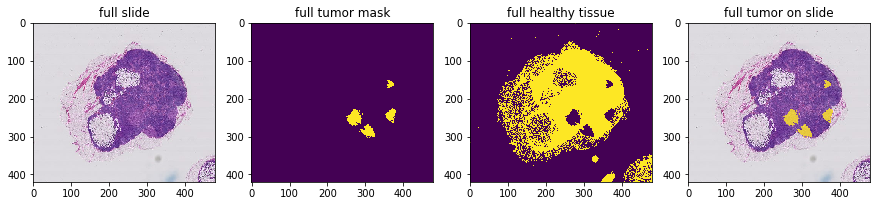

In [0]:
patches, masks, labels = extract_patches(slide, tumor_mask, 7, plot_patch=True)

In [0]:
# Get tumors and healthy patches and save patches, maskes and labels as .npy file to Google Drive
patches, masks, labels = extract_patches_from_slide_id('091', 7, 200, force_reload=True)

======Start Extracting Patch ID 091 Level 7======
Preprocessing data...
===Start Extracting patches..===
#tumorous tissue pixels: 2924, #healthy tissue pixels: 59667
Tumor Patches: 80, Healthy Patches: 120
Time: 0.27 min
===Patch Extraction Done!===
Wrote to /content/drive/My Drive/4995-final/preprocessed/patch_091_lvl_7.npy
Wrote to /content/drive/My Drive/4995-final/preprocessed/mask_091_lvl_7.npy
Wrote to /content/drive/My Drive/4995-final/preprocessed/labels_091_lvl_7.npy
Time: 0.30 min
======Finish Extracting Patch ID 091 Level 7======


In [0]:
# Force_reload = False means we will load the data we saved from Google Drive if the files already exist
patches, masks, labels = extract_patches_from_slide_id('091', 7, 200, force_reload=False)

======Start Extracting Patch ID 091 Level 7======
Data already exists! Preload existing data...
Total tumors: 80
Time: 0.04 min
======Finish Extracting Patch ID 091 Level 7======


## Sanity Check our training Data

Necessary checks to ensure our pipeline is correct.

Using plot_sample_patches from left to right, we show slide, tumor mask and slide plus tumor mask. For the tumor mask on slide, we show the centre with red square. Top two rows do not have tumors at the center, which has label 0 below two rows have tumors at the center with label 1.

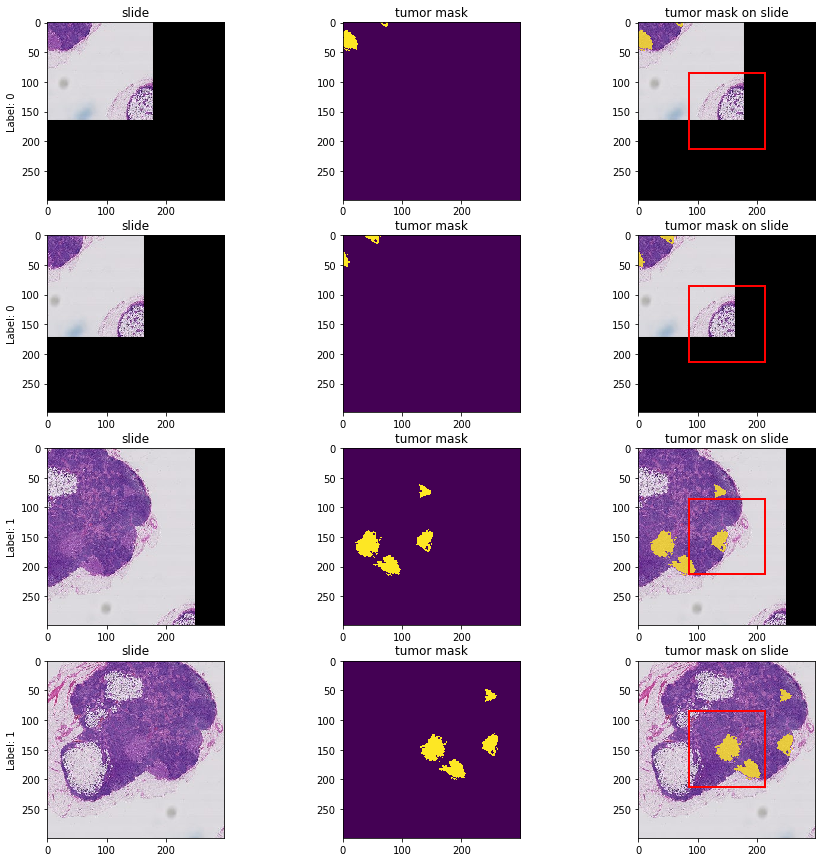

In [0]:
plot_sample_patches(patches, masks)

In [0]:
# patches, masks, labels = extract_patches_from_slide_id('091', 4, 200, force_reload=True)

# Plots of extracted patches: slides, tumor masks, tumor mask on slides

In [0]:
# Set force_reload = False to get the data we saved
patches, masks, labels = extract_patches_from_slide_id('091', 4, 200, force_reload=False)

======Start Extracting Patch ID 091 Level 4======
Data already exists! Preload existing data...
Total tumors: 80
Time: 0.04 min
======Finish Extracting Patch ID 091 Level 4======


Below are patches extracted from slide 091 at level 4, tumor mask on slide shows if there is tumor at the centre.

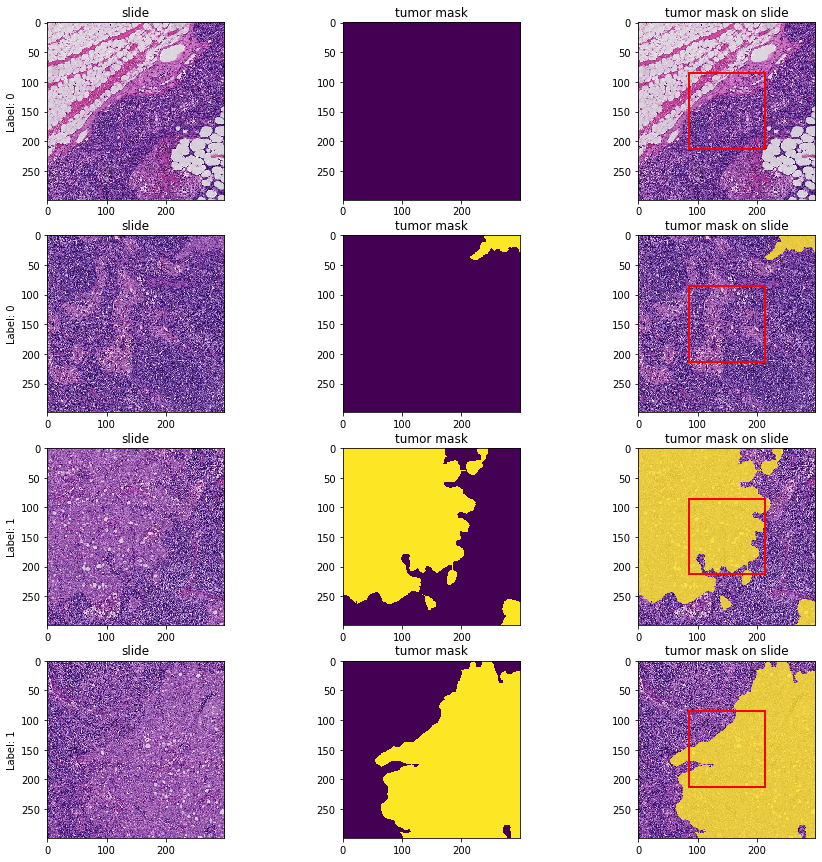

In [0]:
plot_sample_patches(patches, masks)

# Save Precomputed Patches to GDrive

To save resources and time, we precomputed the  patches, mask and labels from several slides into google drive and preload them for subsequent processing: training and modelling evaluation

In [0]:
slide_ids = ['001','057','031','016','075','005','078','084','012',
             '019','064','035','059','002','081','023']

for slide_id in slide_ids:
  patches, masks, labels = extract_patches_from_slide_id(slide_id, 
                                                         5, 
                                                         200, 
                                                         force_reload=True)

======Start Extracting Patch ID 001 Level 5======
Preprocessing data...
===Start Extracting patches..===
#tumorous tissue pixels: 11116, #healthy tissue pixels: 1979081
Tumor Patches: 80, Healthy Patches: 120
Time: 0.28 min
===Patch Extraction Done!===
Wrote to /content/drive/My Drive/4995-final/preprocessed/patch_001_lvl_5.npy
Wrote to /content/drive/My Drive/4995-final/preprocessed/mask_001_lvl_5.npy
Wrote to /content/drive/My Drive/4995-final/preprocessed/labels_001_lvl_5.npy
Time: 0.28 min
======Finish Extracting Patch ID 001 Level 5======
